In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [54]:
# Open data file
df = pd.read_csv('2_Data for EDA_batch.csv')
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [55]:
X = df[['r_d_n-0', 'r_d_n-1', 'r_d_n-2', 'r_d_n-3', 'r_d_n-4', 'r_d_n-5', 'days_since_rain', 'month', 'season_int']]
y = df['target']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

In [57]:
# naive benchmark
base_acc = y_train.value_counts(normalize=True)
base_acc

target
0    0.808482
1    0.191518
Name: proportion, dtype: float64

In [58]:
pd.DataFrame({
    "train": pd.Series(y_train).value_counts(),
    "test":  pd.Series(y_test).value_counts()
})

,train,test
target,,
0,2440,797
1,578,209


In [59]:
knn_pipe = Pipeline([('scale', StandardScaler()),
                     ('model', KNeighborsClassifier(n_neighbors = 2))])

In [60]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=2))])

In [61]:
knn_pipe.score(X_train, y_train)

0.9058979456593771

In [62]:
knn_pipe.score(X_test, y_test)

0.8131212723658051

In [63]:
train_error = []
test_error = []
for k in range(11, 14, 1):
    knn_pipe = Pipeline([('scale', StandardScaler()),
                     ('model', KNeighborsClassifier(n_neighbors = k))])
    knn_pipe.fit(X_train, y_train)
    train_error.append(knn_pipe.score(X_train, y_train))
    test_error.append(knn_pipe.score(X_test, y_test))

knn_errors = pd.DataFrame({'k': range(11, 14, 1),
                           'train score': train_error,
                           'test score': test_error})
knn_errors

,k,train score,test score
0,11,0.866799,0.830020
1,12,0.866468,0.834990
2,13,0.866137,0.832008


In [64]:
best_k = knn_errors.loc[knn_errors['test score'] == knn_errors['test score'].max(), 'k'].values[0]
print(best_k)

12


In [65]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [66]:
k = best_k
knn_pipe = Pipeline([('scale', StandardScaler()),
                     ('model', KNeighborsClassifier(n_neighbors = k))])
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=12))])

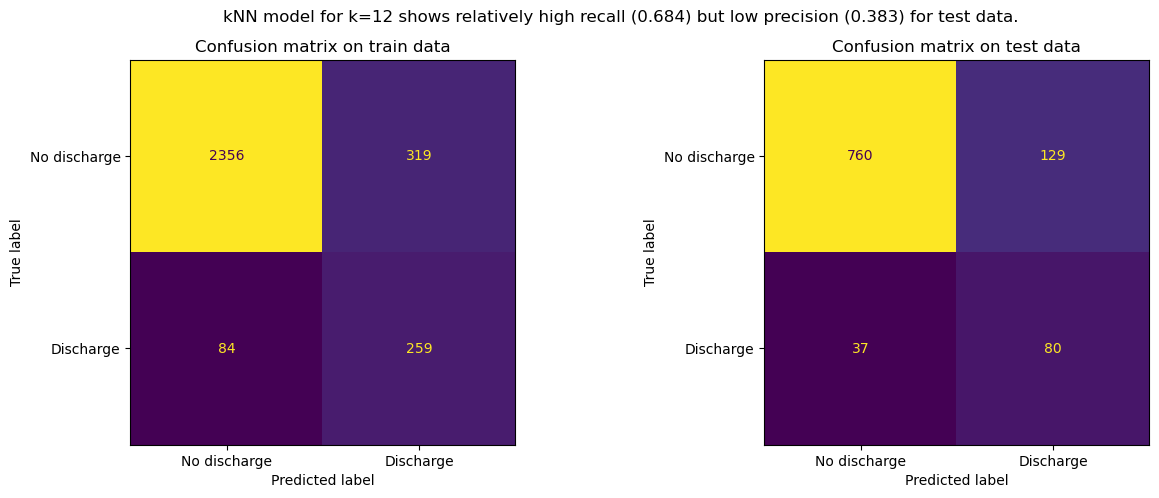

In [67]:
train_cmat = confusion_matrix(knn_pipe.predict(X_train), y_train)
test_cmat = confusion_matrix(knn_pipe.predict(X_test), y_test)
train_disp = ConfusionMatrixDisplay(train_cmat, display_labels=['No discharge', 'Discharge'])
test_disp = ConfusionMatrixDisplay(test_cmat, display_labels=['No discharge', 'Discharge'])
#plt.rcParams.update({'font.size'=20})
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
fig.suptitle('kNN model for k=12 shows relatively high recall (0.684) but low precision (0.383) for test data.')
train_disp.plot(ax = ax[0], colorbar = False)
ax[0].set_title('Confusion matrix on train data')
test_disp.plot(ax = ax[1], colorbar = False)
ax[1].set_title('Confusion matrix on test data');

In [68]:
tn, fp, fn, tp = test_cmat.ravel()
test_precision = tp / (tp + fp)
test_recall = tp / (tp + fn)
print(f'Test set precision: {test_precision: .3f}')
print(f'Test set recall: {test_recall: .3f}')

Test set precision:  0.383
Test set recall:  0.684
